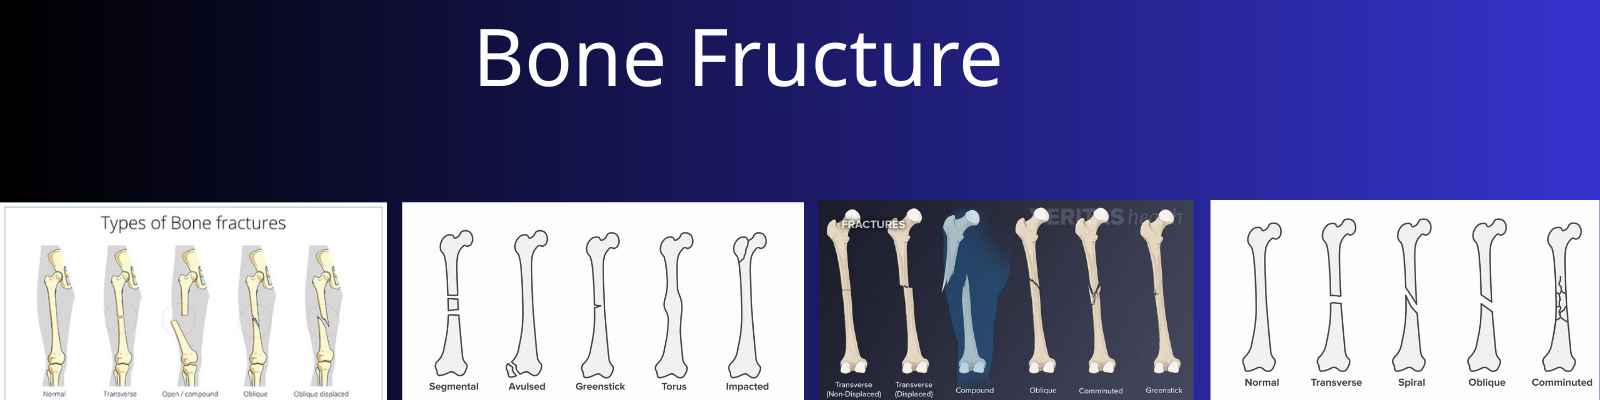

# Introduction

This project presents an automated bone fracture detection system using Transfer Learning with the MobileNetV2 architecture. Medical images were classified into fractured and non-fractured categories. By leveraging a pre-trained model, we achieved efficient training with limited data while maintaining high accuracy. The performance was evaluated using a confusion matrix and classification report. The results demonstrate that MobileNetV2 can be effectively used for fast and reliable fracture detection, supporting quicker diagnosis in clinical environments.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/bone-fracture-dataset/Bone fracture dataset/Bone fracture dataset/Dataset'):
    for filename in filenames:
        pass  # Dataset file paths are hidden by skipping print()

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# Import Libraries

To build and evaluate the bone fracture detection model, several Python libraries were used:

 NumPy & Pandas: For numerical operations and data handling.

 Matplotlib: For plotting graphs and visualizations.

 TensorFlow & Keras: For loading the pre-trained MobileNetV2 model and building the deep learning pipeline.

 Scikit-learn: For performance evaluation using confusion matrix and classification report.

 OS: For interacting with the file system.

These libraries are essential for image preprocessing, model training, and performance evaluation in this computer vision task.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

2025-05-01 19:11:32.970684: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746126693.190680      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746126693.252651      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Prepare Dataset

In this section, we load and preprocess the bone fracture image dataset. The dataset is organized into class-wise folders. We use ImageDataGenerator to:

Rescale the pixel values to [0, 1] range.

Split the data into training and validation sets (80% training, 20% validation).

Flow images directly from the directory for efficient memory usage.

The images are resized to 224x224 pixels, and the data is loaded in batches to support faster training.

In [3]:
data_dir = '/kaggle/input/bone-fracture-dataset/Bone fracture dataset/Bone fracture dataset/Dataset'
img_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 1702 images belonging to 2 classes.
Found 425 images belonging to 2 classes.


 # Build Transfer Learning Model

In this section, we implement a Transfer Learning approach using the MobileNetV2 architecture. MobileNetV2 is a lightweight and efficient convolutional neural network pre-trained on the ImageNet dataset.

Steps:
Load the MobileNetV2 model without the top (fully connected) layers.

Freeze the base model layers to retain the pre-trained features.

Add a GlobalAveragePooling2D layer to reduce the feature map.

Add a Dense output layer with softmax activation to classify images into respective categories.

This approach helps in achieving high accuracy even with limited training data by reusing the powerful features learned by MobileNetV2 on a large-scale dataset.



In [4]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


I0000 00:00:1746126705.747406      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train the Model

In this step, we train the Transfer Learning model using the prepared training and validation datasets.

Key Points:
Optimizer: Adam optimizer is used for efficient gradient descent.

Loss Function: Categorical crossentropy is used for multi-class classification.

Metrics: Model is evaluated based on accuracy.

Epochs: The model is trained for a defined number of epochs (e.g., 10–20) to learn features from the dataset.

A validation set is used to monitor the model's generalization performance and prevent overfitting.

In [5]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746126717.441307      72 service.cc:148] XLA service 0x79b300112010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746126717.442339      72 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746126718.396849      72 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/54 ━━━━━━━━━━━━━━━━━━━━ 11:29 13s/step - accuracy: 0.1250 - loss: 1.4180

I0000 00:00:1746126721.865072      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 494ms/step - accuracy: 0.8668 - loss: 0.3986 - val_accuracy: 0.9576 - val_loss: 0.0796
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - accuracy: 0.9875 - loss: 0.0494 - val_accuracy: 0.9906 - val_loss: 0.0299
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - accuracy: 0.9994 - loss: 0.0126 - val_accuracy: 0.9906 - val_loss: 0.0179
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 200ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0102
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9906 - val_loss: 0.0105
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9906 - val_loss: 0.0121
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 1.0000 - loss: 9.1022e-04 - val_accuracy: 1.0000 - val_loss: 0.0073
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - accuracy: 1.0000 - loss: 6.4372e-04 - val_accurac

# Training vs Validation Accuracy

To evaluate the model’s learning performance, we visualize the training and validation accuracy over epochs.

Why It Matters:
Helps identify overfitting (high training accuracy but low validation accuracy).

Helps understand underfitting (both accuracies are low).

A well-performing model shows a close trend between training and validation accuracy.

We use matplotlib to plot the accuracy curves from the training history.

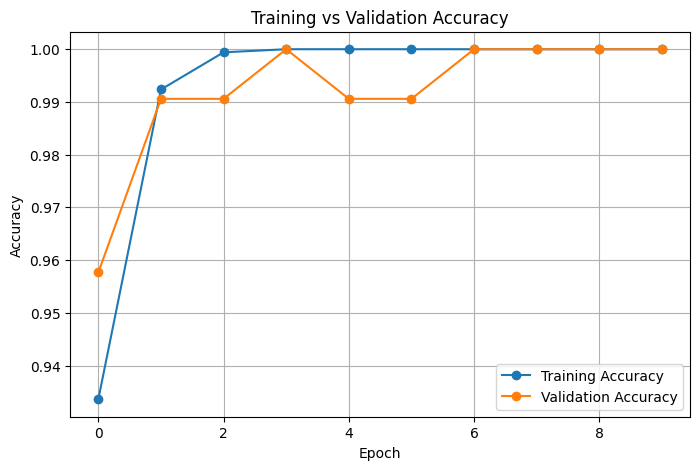

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Training vs Validation Loss

### Training Loss vs Validation Loss

- **Training Loss**:
  - Represents the error on the training data.
  - It indicates how well the model is performing on the data it has already seen.
  - During training, the model tries to minimize this loss by adjusting its weights and biases.

- **Validation Loss**:
  - Represents the error on a separate validation dataset that the model hasn't seen during training.
  - It helps assess how well the model generalizes to new, unseen data.
  - If the validation loss is high, it suggests that the model is not generalizing well to new data.

### Key Differences:
- **Overfitting**: If the training loss decreases significantly while the validation loss increases, it indicates that the model is overfitting to the training data.
- **Underfitting**: If both training and validation losses are high, the model is likely underfitting and failing to learn the underlying patterns of the data.
- **Ideal Situation**: The training loss and validation loss should both decrease over time. If they both converge and stabilize, the model is learning effectively and generalizing well.


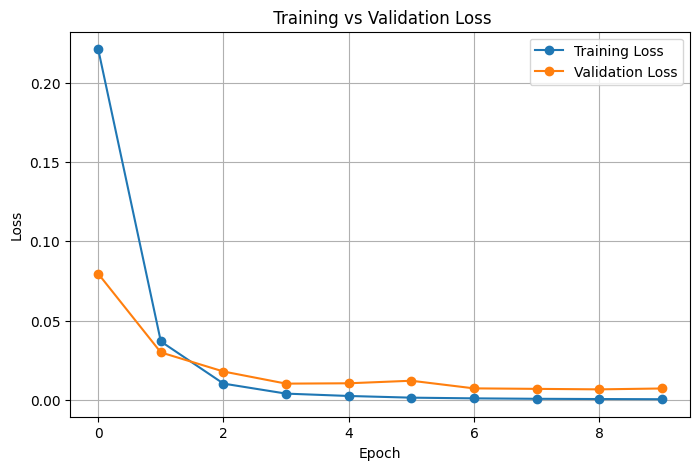

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title(' Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Confusion Matrix

### Confusion Matrix

A **Confusion Matrix** is used to evaluate classification models by comparing predicted and actual values.

#### Components:
- **True Positive (TP)**: Correctly predicted positive instances.
- **True Negative (TN)**: Correctly predicted negative instances.
- **False Positive (FP)**: Incorrectly predicted positive instances.
- **False Negative (FN)**: Incorrectly predicted negative instances.

|               | Predicted Positive | Predicted Negative |
|---------------|--------------------|--------------------|
| **Actual Positive** | TP                 | FN                 |
| **Actual Negative** | FP                 | TN                 |

#### Metrics:
- **Accuracy**: \(\frac{TP + TN}{TP + TN + FP + FN}\)
- **Precision**: \(\frac{TP}{TP + FP}\)
- **Recall**: \(\frac{TP}{TP + FN}\)
- **F1-Score**: \(\frac{2 \times Precision \times Recall}{Precision + Recall}\)

The confusion matrix helps in assessing a model's classification performance.


14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 475ms/step


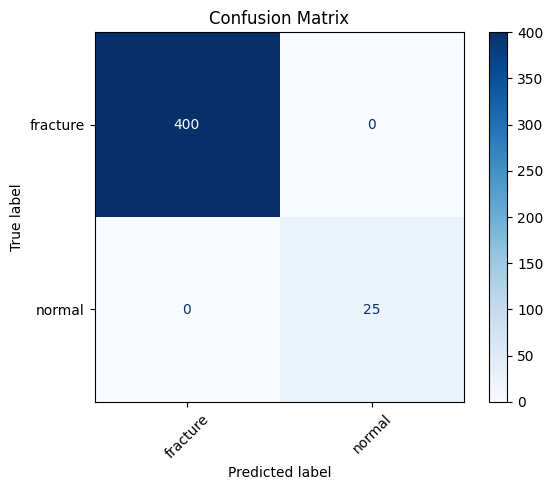

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(val_data, verbose=1)
y_pred_labels = np.argmax(y_pred, axis=1)

y_true = val_data.classes

class_names = list(val_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


# Classification Report

### Classification Report

A **Classification Report** provides a detailed evaluation of a classification model's performance. It includes metrics such as Precision, Recall, F1-Score, and Support for each class.

#### Key Metrics:
- **Precision**: The percentage of correct positive predictions.
  \[
  \text{Precision} = \frac{TP}{TP + FP}
  \]
- **Recall**: The percentage of actual positives correctly predicted.
  \[
  \text{Recall} = \frac{TP}{TP + FN}
  \]
- **F1-Score**: The harmonic mean of Precision and Recall.
  \[
  \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  \]
- **Support**: The number of true instances for each class.

#### Example Output:

| Class       | Precision | Recall | F1-Score | Support |
|-------------|-----------|--------|----------|---------|
| Class 1     | 0.85      | 0.90   | 0.87     | 100     |
| Class 2     | 0.80      | 0.75   | 0.77     | 120     |
| **Average** | 0.82      | 0.83   | 0.82     | 220     |

The classification report helps evaluate how well a model performs on each class.


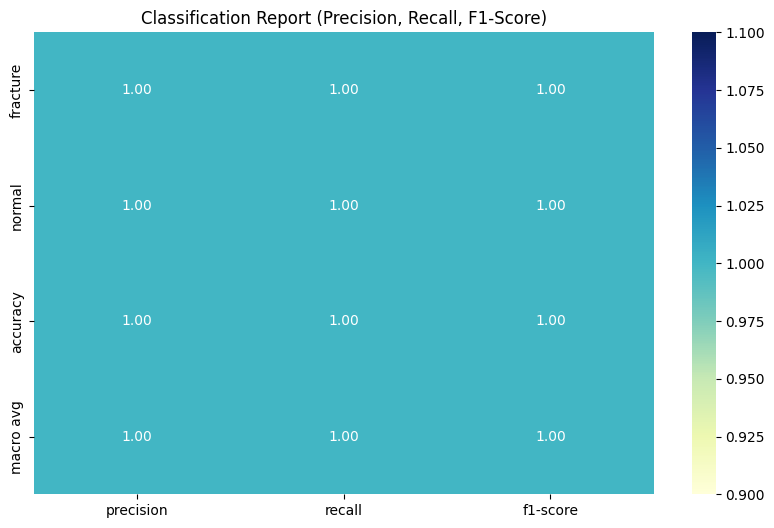

In [9]:
report = classification_report(y_true, y_pred_labels, target_names=val_data.class_indices.keys(), output_dict=True)

df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report (Precision, Recall, F1-Score)")
plt.show()


# Sample Prediction Visualization


This concise explanation covers the purpose and an example of **Sample Prediction Visualization** in the context of classification tasks.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


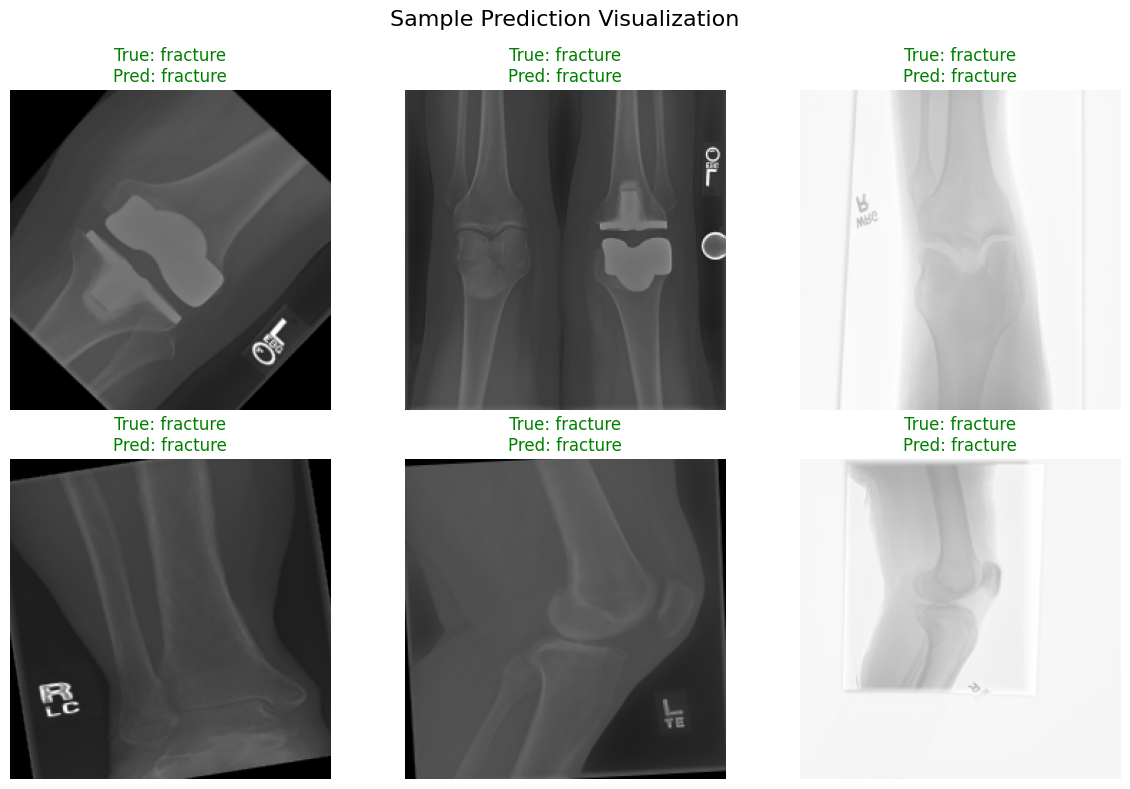

In [10]:
class_names = list(val_data.class_indices.keys())
val_data.reset()

plt.figure(figsize=(12, 8))
for i in range(6):
    image, label = val_data[i][0][0], val_data[i][1][0]
    true_label = class_names[np.argmax(label)]
    prediction = model.predict(tf.expand_dims(image, axis=0))
    pred_label = class_names[np.argmax(prediction)]

    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title(f"True: {true_label}\nPred: {pred_label}",
              color="green" if true_label == pred_label else "red")
    plt.axis("off")
plt.tight_layout()
plt.suptitle("Sample Prediction Visualization", fontsize=16)
plt.subplots_adjust(top=0.88)
plt.show()


# Learning Rate vs Loss


This explanation provides a brief overview of the relationship between **Learning Rate** and **Loss** in training machine learning models.


In [11]:
class LrLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.lrs = []

    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(epoch)
        lr_value = tf.keras.backend.get_value(lr)
        self.lrs.append(lr_value)

        print(f"Epoch {epoch+1}: Learning Rate = {lr_value}")


In [12]:
lr_logger = LrLogger()

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[lr_logger]
)


Epoch 1/10
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.9458e-04Epoch 1: Learning Rate = 0.0010000000474974513
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 1.0000 - loss: 3.9248e-04 - val_accuracy: 0.9906 - val_loss: 0.0081
Epoch 2/10
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 3.1148e-04Epoch 2: Learning Rate = 0.0010000000474974513
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - accuracy: 1.0000 - loss: 3.1029e-04 - val_accuracy: 0.9906 - val_loss: 0.0081
Epoch 3/10
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.1429e-04Epoch 3: Learning Rate = 0.0010000000474974513
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 202ms/step - accuracy: 1.0000 - loss: 2.1516e-04 - val_accuracy: 1.0000 - val_loss: 0.0064
Epoch 4/10
53/54 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.0814e-04Epoch 4: Learning Rate = 0.0010000000474974513
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 1.0000 - loss: 2.0795e-04 - val_accu

## Graph

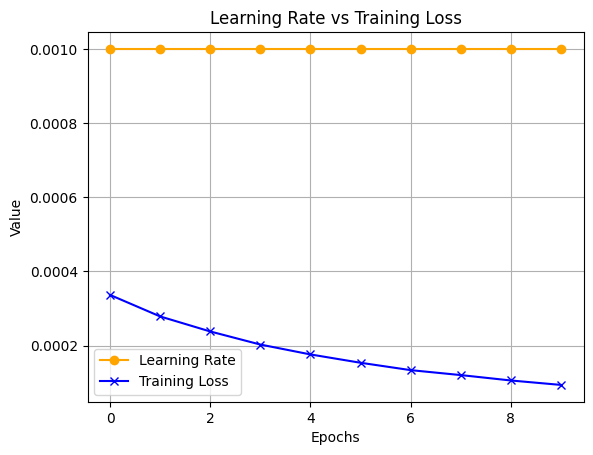

In [13]:
plt.plot(lr_logger.lrs, label="Learning Rate", color='orange', marker='o')
plt.plot(history.history['loss'], label="Training Loss", color='blue', marker='x')
plt.title("Learning Rate vs Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


**Thank you**